In [1]:
from bisect import bisect_left
from configparser import ConfigParser
from sys import argv

from lxml import etree
from shapely.affinity import rotate
from shapely.geometry import Polygon

from constants import (BLOCK_REGISTRY,
                       MULTIPLIER,
                       GROUND_HEIGHT,
                       BLOCK_STRING,
                       PIG_STRING,
                       LEVEL_TEMPLATE)


class Structure:
    @staticmethod
    def get_shape_width(shape):
        bounds = shape.bounds
        return bounds[2] - bounds[0]


    @staticmethod
    def get_shape_height(shape):
        bounds = shape.bounds
        return bounds[3] - bounds[1]


    @staticmethod
    def get_number_of_instances_required_to_cover_distance(covered_distance, covering_distance):
        if covered_distance < 0:
            return 0
        number_of_instances, remainder = divmod(int(covered_distance * MULTIPLIER),
                                                int(covering_distance * MULTIPLIER))
        if remainder:
            number_of_instances += 1
        return number_of_instances


    @staticmethod
    def transpose_and_invert_blocks(blocks):
        """
        The blocks start from top-left and go towards bottom-right. This is not
        practical when constructing a structure. We want to start from
        bottom-left and go towards top-right. Hence, we transpose and invert
        blocks.
        """
        return [column[::-1] for column in map(list, zip(*blocks))]


    def __init__(self,
                 level_path,
                 shape,
                 primary_block,
                 platform_block,
                 num_primary_blocks_on_x_axis):
        self.level_path = level_path
        self.shape = shape
        self.primary_block = primary_block
        self.platform_block = platform_block
        self.num_primary_blocks_to_cover_pig_width = self.get_number_of_instances_required_to_cover_distance(BLOCK_REGISTRY['pig'].width,
                                                                                                             primary_block.width)
        self.num_primary_blocks_to_cover_pig_height = self.get_number_of_instances_required_to_cover_distance(BLOCK_REGISTRY['pig'].height, 
                                                                                                              primary_block.height)
        self.num_primary_blocks_on_x_axis = num_primary_blocks_on_x_axis
        self.primary_block_factor = self.get_primary_block_factor(num_primary_blocks_on_x_axis)
        self.factored_primary_block_width, self.factored_primary_block_height = self.get_factored_primary_block_dimensions()
        self.num_primary_blocks_on_y_axis = self.get_number_of_instances_required_to_cover_distance(self.get_shape_height(self.shape), 
                                                                                                    self.factored_primary_block_height)
        # This gets only non-empty rows.
        self.original_blocks = [row for row in self.get_blocks() if any(row)]
        self.blocks = self.transpose_and_invert_blocks(self.original_blocks)
        # This is to start from bottom row and go towards the top row, instead
        # of vice-versa.
        self.original_blocks = self.original_blocks[::-1]
        self.platforms = sorted(list(self.get_platforms()))
        self.generate_extra_platforms()
        self.get_platform_blocks()
        self.get_blocks_for_pigs()
        self.vacate_blocks_for_pigs()


    def __str__(self):
        row_strings = []
        for index, row in enumerate(self.original_blocks):
            row_string = f'{index:{len(str(len(self.original_blocks) - 1))}}' + ' ' + ('_' if index in self.platforms else ' ')
            row_string += ''.join(['▉' if block is True else ' ' for block in row])
            row_strings.append(row_string)
        return '\n'.join(row_strings[::-1])


    def get_primary_block_factor(self, num_primary_blocks):
        '''Normally every block has a width and height. However, since we want to
        decide on the number of primary blocks that will exist on an axis of the
        structure, we want to proportionate the primary block dimensions according
        to this number. Hence, we get the multiplier needed to get this number.'''
        shape_width = self.get_shape_width(self.shape)
        target_primary_block_width = shape_width / num_primary_blocks
        return target_primary_block_width / self.primary_block.width


    def get_factored_primary_block_dimensions(self):
        return (self.primary_block.width * self.primary_block_factor,
                self.primary_block.height * self.primary_block_factor)


    def is_tile_mostly_in_shape(self, tile):
        '''We designate an area for the structure and we partition it into small,
        equal tiles. The tiles can be of any size and shape but for simplicity, they
        are usually square. The tiles represent the "primary blocks" that are
        going to form the structure in the output.

        Then, in order to determine whether there should be a block present on a
        given tile or not, we find the intersection area of the tile with the
        structure SVG which is given as the input and if the intersection area is
        greater than half of the tile area, then we return true. Otherwise, we
        return false.
        '''
        return tile.intersection(self.shape).area > tile.area / 2


    def get_blocks(self):
        # Blocks is a boolean array indicating whether or not there is a block
        # in the indicated index.
        blocks = []
        for row in range(self.num_primary_blocks_on_y_axis):
            blocks_in_row = []
            y = self.shape.bounds[1] + row * self.factored_primary_block_height
            for column in range(self.num_primary_blocks_on_x_axis):
                x = self.shape.bounds[0] + column * self.factored_primary_block_width
                tile = Polygon([(x,y),
                                (x + self.factored_primary_block_width, y),
                                (x + self.factored_primary_block_width, y + self.factored_primary_block_height),
                                (x, y + self.factored_primary_block_height)])
                if self.is_tile_mostly_in_shape(tile):
                    blocks_in_row.append(True)
                else:
                    blocks_in_row.append(False)
            blocks.append(blocks_in_row)
        return blocks


    def get_platforms(self):
        '''In order to support blocks without anything underneath, we need to
        insert platforms.
        '''
        platforms = set()
        for column in self.blocks:
            last_element_is_a_gap = True
            for row, tile in reversed(list(enumerate(column))):
                if tile:
                    last_element_is_a_gap = False
                else:
                    if not last_element_is_a_gap:
                        platforms.add(row + 1)
                    last_element_is_a_gap = True
        return platforms


    def generate_extra_platforms(self):
        if self.platforms:
            first_platform = self.platforms[0]
            last_platform = self.platforms[-1]
        else:
            first_platform = last_platform = len(self.original_blocks)
        self.platforms = set(self.platforms)
        for i in range(first_platform - self.num_primary_blocks_to_cover_pig_height, self.num_primary_blocks_to_cover_pig_height - 1, -self.num_primary_blocks_to_cover_pig_height):
            self.platforms.add(i)
        for i in range(last_platform + self.num_primary_blocks_to_cover_pig_height, len(self.original_blocks) + 1, self.num_primary_blocks_to_cover_pig_height):
            self.platforms.add(i)
        # TODO Insert extra platforms between the first and the last platform
        self.platforms = sorted(list(self.platforms))


    def primary_blocks_exist_above(self, index, lateral_distance):
        '''
        Checks above of a given lateral distance in order to determine if there
        are primary blocks above or not. If not, returns False to signal that
        a platform block should not be inserted to this location.
        '''
        start_index = self.get_number_of_instances_required_to_cover_distance(lateral_distance - self.platform_block.width / 2, self.primary_block.width)
        if start_index < 0:
            start_index = 0
        end_index = self.get_number_of_instances_required_to_cover_distance(lateral_distance + self.platform_block.width / 2, self.primary_block.width)
        if True in self.original_blocks[index][start_index:end_index]:
            return True
        else:
            return False


    def add_if_primary_blocks_exist_above(self, index, lateral_distance, lateral_distances, append=True):
        if self.primary_blocks_exist_above(index, lateral_distance):
            if append:
                lateral_distances.append(lateral_distance)
            else:
                lateral_distances.insert(0, lateral_distance)


    def get_lateral_distances_for_platform_blocks(self, index):
        lateral_distances = []
        # For the imaginary platform that is located right above the top of the
        # structure, don't place any platform blocks.
        # FIXME Actually instead of returning nothing, we might need to return a
        # full platform here. The reason is that we place the pigs if there is a
        # platform block exists above. If no platform block exists, we don't
        # place a pig. This defeats the whole purpose of the (imaginary)
        # platform that is located right above the top of the structure. Hence,
        # we either need to insert a full platform here, or change the way that
        # the preparation and insertion of the pigs are done.
        if index == len(self.original_blocks):
            return lateral_distances
        number_of_empty_blocks_before_the_first_non_empty_block = self.original_blocks[index].index(True)
        number_of_empty_blocks_after_the_last_non_empty_block = self.original_blocks[index][::-1].index(True)
        number_of_non_empty_blocks = len(self.original_blocks[index])
        number_of_primary_blocks_to_cover = (number_of_non_empty_blocks
                                           - number_of_empty_blocks_before_the_first_non_empty_block
                                           - number_of_empty_blocks_after_the_last_non_empty_block)
        platform_center_distance = ((number_of_empty_blocks_before_the_first_non_empty_block
                                   + number_of_primary_blocks_to_cover / 2)) * self.primary_block.width
        distance_to_cover = number_of_primary_blocks_to_cover * self.primary_block.width
        number_of_platform_blocks = self.get_number_of_instances_required_to_cover_distance(distance_to_cover, self.platform_block.width)
        if number_of_platform_blocks % 2 is 1:
            self.add_if_primary_blocks_exist_above(index, platform_center_distance, lateral_distances)
            number_of_platform_blocks -= 1
            left_lateral_distance = platform_center_distance - self.platform_block.width
            right_lateral_distance = platform_center_distance + self.platform_block.width
        else:
            left_lateral_distance = platform_center_distance - self.platform_block.width / 2
            right_lateral_distance = platform_center_distance + self.platform_block.width / 2
        for i in range(int(number_of_platform_blocks / 2)):
            self.add_if_primary_blocks_exist_above(index, left_lateral_distance, lateral_distances, False)
            self.add_if_primary_blocks_exist_above(index, right_lateral_distance, lateral_distances)
            left_lateral_distance -= self.platform_block.width
            right_lateral_distance += self.platform_block.width
        return lateral_distances


    def get_platform_blocks(self):
        self.platform_blocks = [self.get_lateral_distances_for_platform_blocks(platform) for platform in self.platforms]


    def get_rows_to_place_pigs_under(self):
        '''
        Pigs are placed under the platforms where the previous (lower) platform
        is at least 'self.num_primary_blocks_to_cover_pig_height' lower than the
        current platform.
        '''
        rows_to_place_pigs_under = []
        if self.platforms[0] >= self.num_primary_blocks_to_cover_pig_height:
            rows_to_place_pigs_under.append(self.platforms[0])
        for index, platform in enumerate(self.platforms[1:]):
            if platform - self.platforms[index] >= self.num_primary_blocks_to_cover_pig_height:
                rows_to_place_pigs_under.append(platform)
        return rows_to_place_pigs_under


    def get_platform_center_index(self, lateral_distance):
        platform_block_start = lateral_distance - self.platform_block.width / 2
        platform_block_end = lateral_distance + self.platform_block.width / 2
        start_index = self.get_number_of_instances_required_to_cover_distance(platform_block_start, self.primary_block.width)
        end_index = self.get_number_of_instances_required_to_cover_distance(platform_block_end, self.primary_block.width)
        return int((start_index + end_index) / 2)


    def get_blocks_for_pigs(self):
        '''
        Populates self.pig_indices so that it will become a dictionary, where
        keys are row indices and values are the places where to place the pig.
        Note that each value is a single index. That is, each pig is represented
        by the horizontal center, and vertical top primary block. The necessary
        calculations are done in vacate_blocks_for_pigs to ensure correct
        insertion.
        '''
        self.pig_indices = {}
        # FIXME We find the pig indices by checking out the platform blocks. If
        # there are no platform blocks, no pigs can be inserted. You might want
        # to accomodate for the cases of inserting a pig to the top of the
        # structure. That case does not require any platforms.
        if not self.platforms:
            return
        rows_to_place_pigs_under = self.get_rows_to_place_pigs_under()
        for row in rows_to_place_pigs_under:
            for platform in self.platform_blocks[self.platforms.index(row)]:
                self.pig_indices.setdefault(row, []).append(self.get_platform_center_index(platform))


    def vacate_blocks_for_pigs(self):
        # Refer to "pattern_for_vacating_blocks_for_pigs.txt" for more
        # information.
        offsets_for_blocks_to_vacate = [int(-i / 2) if i % 2 == 0 else int((i + 1) / 2) for i in range(self.num_primary_blocks_to_cover_pig_width)]
        # Since the middle of the width is the left element of the center for
        # pig widths with an even number of primary blocks, the following
        # calculation is required for the left column.
        half_of_num_primary_blocks_to_cover_pig_width, remainder = divmod(self.num_primary_blocks_to_cover_pig_width,
                                                                          2)
        offset_for_block_to_fill_on_left = half_of_num_primary_blocks_to_cover_pig_width + (1 if remainder else 0)
        offset_for_block_to_fill_on_right = half_of_num_primary_blocks_to_cover_pig_width + 1

        for row_index in self.pig_indices:
            for block_index in self.pig_indices[row_index]:
                for row_index_offset in range(self.num_primary_blocks_to_cover_pig_height):
                    row_index_of_block_to_vacate = row_index - 1 - row_index_offset
                    for column_index_offset in offsets_for_blocks_to_vacate:
                        column_index_of_block_to_vacate = block_index + column_index_offset
                        if column_index_of_block_to_vacate > -1 and column_index_of_block_to_vacate < len(self.original_blocks[row_index_of_block_to_vacate]):
                            self.original_blocks[row_index_of_block_to_vacate][column_index_of_block_to_vacate] = False
                    # Make sure there is a column of primary blocks to the left
                    # of the pig.
                    column_index_of_block_to_fill_on_left = block_index - offset_for_block_to_fill_on_left
                    if column_index_of_block_to_fill_on_left > -1:
                        self.original_blocks[row_index_of_block_to_vacate][column_index_of_block_to_fill_on_left] = True
                    else:
                        # TODO We might prepend a column in this case but it was
                        # problemetic when I did that. For example, the
                        # platforms need to be extended to cover this new column
                        # as well.
                        pass
                    # Make sure there is a column of primary blocks to the right
                    # of the pig.
                    column_index_of_block_to_fill_on_right = block_index + offset_for_block_to_fill_on_right
                    if column_index_of_block_to_fill_on_right < len(self.original_blocks[row_index_of_block_to_vacate]):
                        self.original_blocks[row_index_of_block_to_vacate][column_index_of_block_to_fill_on_right] = True
                    else:
                        # TODO We might append a column in this case but it was
                        # problemetic when I did that. For example, the
                        # platforms need to be extended to cover this new column
                        # as well.
                        pass
        self.original_blocks = self.original_blocks[::-1]
        self.blocks = self.transpose_and_invert_blocks(self.original_blocks)
        self.original_blocks = self.original_blocks[::-1]


    def get_block_height(self, block_type, index):
        number_of_platforms = bisect_left(sorted(self.platforms), index)
        if block_type is self.primary_block and index in self.platforms:
            number_of_platforms += 1
        total_platform_height = number_of_platforms * self.platform_block.height
        total_primary_block_height = index * self.primary_block.height
        positioning_distance = block_type.height / 2
        return (GROUND_HEIGHT
              + total_platform_height
              + total_primary_block_height
              + positioning_distance)


    def get_block_string(self, block_type, lateral_distance, vertical_distance, block_material = 'stone'):
        if block_type is not BLOCK_REGISTRY['pig']:
            return BLOCK_STRING.format(block_type.xml_element_name,
                                       block_material,
                                       round(lateral_distance,3),
                                       round(vertical_distance,3),
                                       0)
        else:
            return PIG_STRING.format(block_type.xml_element_name,
                                     block_material,
                                     round(lateral_distance,3),
                                     round(vertical_distance,3),
                                     0)


    def get_xml_elements_for_pigs(self):
        pig_elements = ''
        lateral_distance_correction_index = .5 if self.num_primary_blocks_to_cover_pig_width % 2 == 0 else 0
        for row in self.pig_indices:
            for index in self.pig_indices[row]:
                pig_elements += self.get_block_string(BLOCK_REGISTRY['pig'],
                                                      (index + lateral_distance_correction_index) * self.primary_block.width
                                                      + self.primary_block.width / 2,
                                                      self.get_block_height(self.primary_block, row - self.num_primary_blocks_to_cover_pig_height)
                                                      - self.primary_block.height / 2
                                                      + BLOCK_REGISTRY['pig'].height / 2)
        return pig_elements


    def get_xml_elements(self):
        primary_block_elements = ''
        for column in range(len(self.blocks)):
            for row in range(len(self.blocks[column])):
                if self.blocks[column][row]:
                    primary_block_elements += self.get_block_string(self.primary_block,
                                                                    column * self.primary_block.width + self.primary_block.width / 2,
                                                                    self.get_block_height(self.primary_block, row))
        platform_block_elements = ''
        for platform_blocks_of_row, platform_index in zip(self.platform_blocks, self.platforms):
            for platform_block in platform_blocks_of_row:
                platform_block_elements += self.get_block_string(self.platform_block,
                                                                 platform_block,
                                                                 self.get_block_height(self.platform_block, platform_index))
        pig_elements = self.get_xml_elements_for_pigs()
        return primary_block_elements + platform_block_elements + pig_elements


    def construct_structure(self):
        with open(self.level_path, 'w') as level_file:
            level_file.write(LEVEL_TEMPLATE.strip().format(self.get_xml_elements()))


def get_polygon_from_svg(file):
    # Need to turn image upside down. The reason is that Potrace generates an
    # upside down SVG image and renders it correctly using "scale" function of
    # the "transform" SVG attribute. Since using the "scale" function is not
    # possible in Shapely, we just generate the shape as upside down and then
    # rotate it.
    return rotate(Polygon([tuple([float(c) for c in pair.split(',')])
                    for
                    pair
                    in
                    etree.parse(file).find('.//{http://www.w3.org/2000/svg}polygon').get('points').split()]),
                  180)



In [2]:
svg_file_name = '../../Images/Edited/Buildings/Eiffel_Tower-black-and-white-denoised-polygon.svg'
config = ConfigParser()
config.read('../../config.ini')
print(svg_file_name)
structure = Structure(config.get('DEFAULT', 'LevelPath') + svg_file_name.split('/')[-1].split('.')[0] + '.xml',
                      get_polygon_from_svg(svg_file_name),
                      BLOCK_REGISTRY[config.get('DEFAULT', 'PrimaryBlock')],
                      BLOCK_REGISTRY[config.get('DEFAULT', 'PlatformBlock')],
                      int(config.get('DEFAULT', 'NumberOfPrimaryBlocksOnXAxis')))

../../Images/Edited/Buildings/Eiffel_Tower-black-and-white-denoised-polygon.svg


In [140]:
#randomly build structure
import random

block = [[ random.randint(0,1) for j in range(5)] for i in range(50)]
tr_block = np.fliplr(np.transpose(block))
primary_block_elements = ''
support_block_elements = ''
for column in range(len(tr_block)):
            for row in range(len(tr_block[column])):
                if tr_block[column][row]:
                    primary_block_elements += structure.get_block_string(structure.primary_block,
                                                                         column * 0.22 ,
                                                                         0.22 * row - 3.4,
                                                                         block_material='stone')
                else:
                    support_block_elements += structure.get_block_string(structure.primary_block,
                                                                         column * 0.22 ,
                                                                         0.22 * row-3.4,
                                                                         block_material='ice')
xml = primary_block_elements + support_block_elements
with open(structure.level_path, 'w') as level_file:
            level_file.write(LEVEL_TEMPLATE.strip().format(xml))

In [109]:
# caculate the overall area
for i in range(len(block)):
    for j in range(len(block[i])):
        poly = Polygon([(i * structure.factored_primary_block_width, j *),
                (x + 0.22, y),
                (x + 0.22, y + 0.22),
                (x, y + 0.22)])
poly.intersection(structure.shape).area

IndentationError: expected an indented block (<ipython-input-109-3e384949dccd>, line 6)

11111100000000111111
01111110000001111110
01111110000001111110
00111111000011111100
00111111111111111000
00011111111111111000
00001111111111110000
00001111111111110000
00001111100011110000
00000111100011100000
00000011100011000000
00000011100011000000
00000001100010000000
00000001100010000000
00000001100010000000
00000001100010000000
00000001100010000000
00000000100010000000
00000000100010000000
00000000100010000000
00000000110001000000
00000000110001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000010001000000
00000000001000000000
00000000001000000000
00000000001000000000


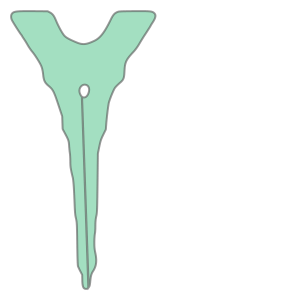

In [148]:
import numpy as np
for i in blcok:
    for j in i:
        if j:
            a = 1
        else:
            a = 0
        print("%-1s" % str(a),end='')
    print()
structure.shape